# Open Movie Database (OMDb) API Data Analysis

## Setup

In [1]:
# Import Packages
import glob
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns

# Ensure Minimum Requirements Are Met
# sys.version

# Python  interpreter version ≥3.7 is required
assert sys.version_info >= (3, 7)

# matplotlib.pyplot
assert mpl.__version__ >= "3.3"

# numpy ≥1.19 is required
assert np.__version__ >= "1.19"

# pandas ≥1.1 is required
assert pd.__version__ >= "1.1"

# seaborn ≥0.11 is required
assert sns.__version__ >= "0.11"

## Import Data

In [2]:
# Using os.path.join() in case loading files on Windows
df = pd.read_csv('movies.csv')

### Investigate Initial Data

In [3]:
display(df.dtypes)
display(df.describe(include='all').T)
df.head()

Title        object
Runtime      object
Genre        object
Awards       object
BoxOffice    object
Rated        object
Director     object
Year          int64
Language     object
dtype: object

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Title,50,50,12 Angry Men,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Runtime,50,38,119 min,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,50,31,"Crime, Drama",6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Awards,50,50,Nominated for 3 Oscars. 17 wins & 13 nominatio...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BoxOffice,43,43,"$56,671,993",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rated,50,9,R,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Director,50,42,Francis Ford Coppola,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,50.0,NaN,NaN,NaN,1982.98,20.866427,1950.0,1967.5,1978.0,1995.5,2019.0
Language,50,19,English,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Title,Runtime,Genre,Awards,BoxOffice,Rated,Director,Year,Language
0,12 Angry Men,96 min,"Crime, Drama",Nominated for 3 Oscars. 17 wins & 13 nominatio...,NaN,Approved,Sidney Lumet,1957,English
1,12 Years a Slave,134 min,"Biography, Drama, History",Won 3 Oscars. 242 wins & 337 nominations total,"$56,671,993",R,Steve McQueen,2013,English
2,A Clockwork Orange,136 min,"Crime, Sci-Fi",Nominated for 4 Oscars. 12 wins & 24 nominatio...,"$26,617,553",X,Stanley Kubrick,1971,English
3,A Streetcar Named Desire,122 min,Drama,Won 4 Oscars. 17 wins & 15 nominations total,NaN,M/PG,Elia Kazan,1951,"English, Spanish"
4,Airport,137 min,"Action, Drama, Thriller",Won 1 Oscar. 5 wins & 19 nominations total,"$100,489,151",G,"George Seaton, Henry Hathaway",1970,"English, Italian"


### Clean The Data

In [4]:
# Stripe potential whitespace from beginning and end of values
df["Title"] = df["Title"].str.strip()
df["Awards"] = df["Awards"].str.strip()
df["Rated"] = df["Rated"].str.strip()
df["Director"] = df["Director"].str.strip()
df["Language"] = df["Language"].str.strip()

# Remove potential duplicates
# df.duplicated(subset=["Title"]).sum()
df.drop_duplicates(subset=["Title"], keep="first", inplace=True)

# Runtime

# Convert Runtime "120 min" to 120
df["Runtime"] = df["Runtime"].str.replace(" min", "").astype(int)

# BoxOffice

# Use regex to extract numbers from strings and convert to float
df['BoxOffice'] = df['BoxOffice'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Convert BoxOffice to int64
# Note: Float64 allows for NaN values
# Note: 'float64' and float seem to be different types
df["BoxOffice"] = df["BoxOffice"].astype('Float64')

# Get the BoxOffice mean
bo_mean = df["BoxOffice"].mean()

# Replace BoxOffice <NA> with mean
df["BoxOffice"] = df["BoxOffice"].fillna(bo_mean)

# Convert BoxOffice to int64, we don't need decimals
df["BoxOffice"] = df["BoxOffice"].astype(int)

# Year

# Make Year a date type
# Note: This will format as YYYY-MM-DD and 
# not just the year as might be expected.
df["Year"] = pd.to_datetime(df["Year"], format="%Y")

# Awards

# Split Awards into Wins and Nominations columns
df["Wins"] = df["Awards"].str.extract(r"(\d+) wins")
df["Nominations"] = df["Awards"].str.extract(r"(\d+) nominations")

# Make Wins and Nominations int64 types
df["Wins"] = df["Wins"].astype('Int64')
df["Nominations"] = df["Nominations"].astype('Int64')

# Genre

# Split Genre into multiple columns
# REF: https://practicaldatascience.co.uk/data-science/how-to-split-a-pandas-column-string-or-list-into-separate-columns

# Use str.split() to split the Genre string into a new List column
df['Genre_List'] = df['Genre'].str.split(',')

# Strip whitespace from beginning and end of each value
df['Genre_List'] = df['Genre_List'].apply(lambda x: [item.strip() for item in x])

# Create a Set of all the unique genre names
genre_set = set()
for genre_list in df['Genre_List']:
    genre_set.update(genre_list)

# Check the result
# print(genre_set)

# Creating a prefix var to avoid potential of having 
# two versions and twice the columns(!).
genre_column_prefix = 'is_Genre_'

# Create new DataFrame with a column for each genre
df_genres = pd.DataFrame(columns=genre_set).add_prefix(genre_column_prefix)

# Add each movie's index to the new DataFrame and for each genre in 
# the movie's genre list, set the value to True in the new DataFrame 
# genre column.
for index, genre_list in df['Genre_List'].iteritems():
    df_genres.loc[index] = False
    for genre in genre_list:
        df_genres.at[index, genre_column_prefix + genre] = True

# Check the result
# df_genres

# Use concat() to perform an outer join on the two DataFrames 
# and join them on their index
df = pd.concat([df, df_genres], axis=1)

# Check the first result `Genre_List` values have True values
# in the new Genre_Name columns
df.head(1).T

,0
Title,12 Angry Men
Runtime,96
Genre,"Crime, Drama"
Awards,Nominated for 3 Oscars. 17 wins & 13 nominatio...
BoxOffice,98019866
Rated,Approved
Director,Sidney Lumet
Year,1957-01-01 00:00:00
Language,English
Wins,17


### Investigate the Results

In [5]:
display(df.dtypes)
display(df.describe(include='all', datetime_is_numeric=True).T)
df.head()

Title                         object
Runtime                        int64
Genre                         object
Awards                        object
BoxOffice                      int64
Rated                         object
Director                      object
Year                  datetime64[ns]
Language                      object
Wins                           Int64
Nominations                    Int64
Genre_List                    object
is_Genre_Thriller               bool
is_Genre_Fantasy                bool
is_Genre_Crime                  bool
is_Genre_Family                 bool
is_Genre_Sport                  bool
is_Genre_War                    bool
is_Genre_Sci-Fi                 bool
is_Genre_Mystery                bool
is_Genre_Musical                bool
is_Genre_Film-Noir              bool
is_Genre_Comedy                 bool
is_Genre_Drama                  bool
is_Genre_Western                bool
is_Genre_Romance                bool
is_Genre_Action                 bool
i

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Title,50,50,12 Angry Men,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Runtime,50.0,NaN,NaN,NaN,132.76,91.0,118.0,124.5,142.0,218.0,26.848448
Genre,50,31,"Crime, Drama",6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Awards,50,50,Nominated for 3 Oscars. 17 wins & 13 nominatio...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BoxOffice,50.0,NaN,NaN,NaN,98019866.04,299645.0,44700024.75,97030824.0,107182897.75,460998507.0,86544619.291861
Rated,50,9,R,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Director,50,42,Francis Ford Coppola,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,50,NaN,NaN,NaN,1982-12-24 19:40:48,1950-01-01 00:00:00,1967-07-02 18:00:00,1978-01-01 00:00:00,1995-07-02 12:00:00,2019-01-01 00:00:00,NaN
Language,50,19,English,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wins,50.0,NaN,NaN,NaN,57.72,4.0,13.5,23.0,67.75,308.0,72.814845


,Title,Runtime,Genre,Awards,BoxOffice,Rated,Director,Year,Language,Wins,...,is_Genre_Film-Noir,is_Genre_Comedy,is_Genre_Drama,is_Genre_Western,is_Genre_Romance,is_Genre_Action,is_Genre_History,is_Genre_Adventure,is_Genre_Music,is_Genre_Biography
0,12 Angry Men,96,"Crime, Drama",Nominated for 3 Oscars. 17 wins & 13 nominatio...,98019866,Approved,Sidney Lumet,1957-01-01,English,17,...,False,False,True,False,False,False,False,False,False,False
1,12 Years a Slave,134,"Biography, Drama, History",Won 3 Oscars. 242 wins & 337 nominations total,56671993,R,Steve McQueen,2013-01-01,English,242,...,False,False,True,False,False,False,True,False,False,True
2,A Clockwork Orange,136,"Crime, Sci-Fi",Nominated for 4 Oscars. 12 wins & 24 nominatio...,26617553,X,Stanley Kubrick,1971-01-01,English,12,...,False,False,False,False,False,False,False,False,False,False
3,A Streetcar Named Desire,122,Drama,Won 4 Oscars. 17 wins & 15 nominations total,98019866,M/PG,Elia Kazan,1951-01-01,"English, Spanish",17,...,False,False,True,False,False,False,False,False,False,False
4,Airport,137,"Action, Drama, Thriller",Won 1 Oscar. 5 wins & 19 nominations total,100489151,G,"George Seaton, Henry Hathaway",1970-01-01,"English, Italian",5,...,False,False,True,False,False,True,False,False,False,False


### Check memory usage

In [6]:
df.memory_usage(deep=True)
# A few columns might be candidates for using the Categorical dtype.
# Since this is not a large dataset though, I'll leave some as is.

Index                  400
Title                 3592
Runtime                400
Genre                 3756
Awards                5134
BoxOffice              400
Rated                 2988
Director              3652
Year                   400
Language              3642
Wins                   450
Nominations            450
Genre_List            4000
is_Genre_Thriller       50
is_Genre_Fantasy        50
is_Genre_Crime          50
is_Genre_Family         50
is_Genre_Sport          50
is_Genre_War            50
is_Genre_Sci-Fi         50
is_Genre_Mystery        50
is_Genre_Musical        50
is_Genre_Film-Noir      50
is_Genre_Comedy         50
is_Genre_Drama          50
is_Genre_Western        50
is_Genre_Romance        50
is_Genre_Action         50
is_Genre_History        50
is_Genre_Adventure      50
is_Genre_Music          50
is_Genre_Biography      50
dtype: int64

In [7]:
# Change some columns to Categorical
df["Rated"] = df["Rated"].astype('category')
df["Director"] = df["Director"].astype('category')  # Increased in size
df["Language"] = df["Language"].astype('category')

In [8]:
# Inspect the results
display(df.memory_usage(deep=True))
df.dtypes

Index                  400
Title                 3592
Runtime                400
Genre                 3756
Awards                5134
BoxOffice              400
Rated                  900
Director              4226
Year                   400
Language              2185
Wins                   450
Nominations            450
Genre_List            4000
is_Genre_Thriller       50
is_Genre_Fantasy        50
is_Genre_Crime          50
is_Genre_Family         50
is_Genre_Sport          50
is_Genre_War            50
is_Genre_Sci-Fi         50
is_Genre_Mystery        50
is_Genre_Musical        50
is_Genre_Film-Noir      50
is_Genre_Comedy         50
is_Genre_Drama          50
is_Genre_Western        50
is_Genre_Romance        50
is_Genre_Action         50
is_Genre_History        50
is_Genre_Adventure      50
is_Genre_Music          50
is_Genre_Biography      50
dtype: int64

Title                         object
Runtime                        int64
Genre                         object
Awards                        object
BoxOffice                      int64
Rated                       category
Director                    category
Year                  datetime64[ns]
Language                    category
Wins                           Int64
Nominations                    Int64
Genre_List                    object
is_Genre_Thriller               bool
is_Genre_Fantasy                bool
is_Genre_Crime                  bool
is_Genre_Family                 bool
is_Genre_Sport                  bool
is_Genre_War                    bool
is_Genre_Sci-Fi                 bool
is_Genre_Mystery                bool
is_Genre_Musical                bool
is_Genre_Film-Noir              bool
is_Genre_Comedy                 bool
is_Genre_Drama                  bool
is_Genre_Western                bool
is_Genre_Romance                bool
is_Genre_Action                 bool
i

## Define Chart Theme

In [9]:
# Use a custom font
# Add every font in the specified location
font_dir = ['Raleway/static/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Check font is accessible
font_manager.findfont("Raleway")

# Create a variable for this themes values so
# it can be turned on and off when needed.
# Some plots need more work to look good.
theme_for_bar_charts = {
    'axes.facecolor':'black', 
    'figure.facecolor':'black',
    'axes.labelcolor': 'gold',
    'text.color': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'axes.spines.top': 'false',
    'axes.spines.right': 'false',
    'axes.spines.bottom': 'false',
    'axes.spines.left': 'false',
    'grid.color': 'darkgrey',
    'grid.alpha': .65,
    'grid.linestyle': '--',
    'grid.linewidth': 1,
    'font.family': 'Raleway',
    'figure.titlesize': 36,
    'figure.titleweight': 'bold',
    # 'figure.labelweight': 'semibold', # not working, matplotlib bug?
    # 'figure.labelsize': 14, # not working, matplotlib bug?
    'axes.titlecolor': 'white',
    'axes.titlelocation': 'left',
    'axes.titlepad': 20,
    'axes.titlesize': 36,
    'axes.titleweight': 'bold',
    'axes.labelcolor': 'gold',
    'axes.labelpad': 10,
    'axes.labelsize': 24,
    'axes.labelweight': 'semibold',
}

# Initialize the theme
sns.set_theme(style='dark', font_scale = 1.5, rc=theme_for_bar_charts)

scatter_dots = {
  's': 150,
  'edgecolor': 'black',
  'linewidth': 1,
  'alpha': 0.5
}

line_style = {
  'lw': 3,
}

## Data Analysis

### 1. What was the runtime for each movie?

Here I plotted the runtimes for each movie in a horizontal bar chart sorted from longest runtime at the top to shortest runtime at the bottom. This shows the runtime of each movie along with the distribution of runtimes.

Text(0, 0.5, 'Movie Title')

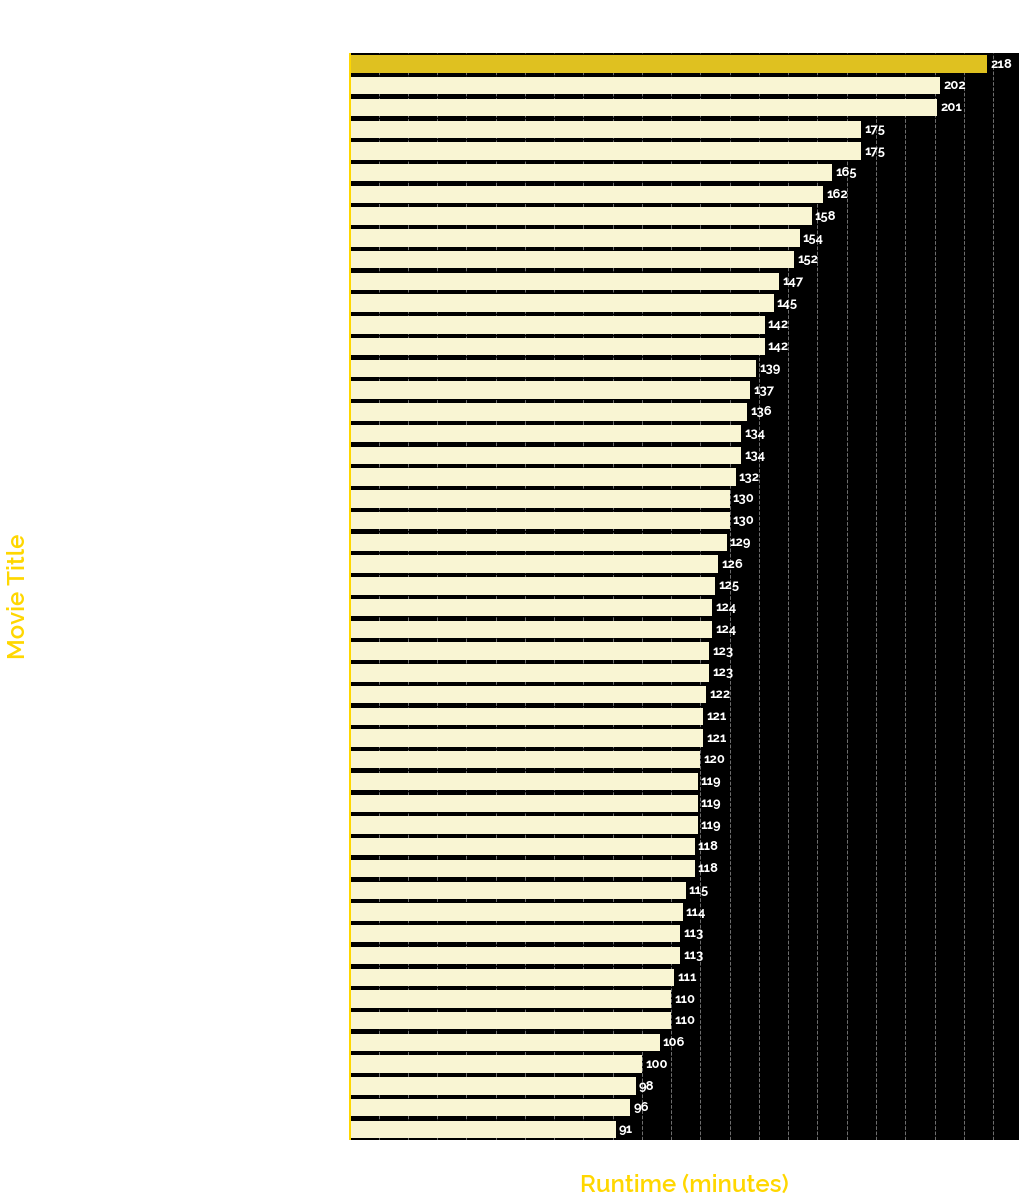

In [10]:
# Create a new DataFrame with only movie titles and their runtime sorted by runtime
df_runtimes = df[["Title", "Runtime"]].sort_values(by="Runtime", ascending=False)

# Use gold for bar with max value and grey/silver for all other bars
cols = ['lemonchiffon' if (x < max(df_runtimes.Runtime)) else 'gold' for x in df_runtimes.Runtime]

# Plot each movie with its runtime length using specified colors
ax = sns.barplot(data=df_runtimes, x="Runtime", y="Title", palette=cols, linewidth=0)

# Add more x axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

# Label each bar
for b in ax.patches:
  height = b.get_height() # height of each horizontal bar is the same
  width = b.get_width() # width of bar is the value of the bar
  # adding text to each bar
  ax.text(
    x = width + 1, # x-coordinate position of data label, padded to right of bar
    y = b.get_y() + (height / 2), # y-coordinate position of data label, padded to be in the middle of the bar
    s = '{:.0f}'.format(width), # data label, formatted to ignore decimals
    va = 'center', # sets vertical alignment (va) to center
    fontsize=13, # Make font size smaller so it fits better
    weight="bold"
  )

ax.axvline(x=0, linewidth=4, color='gold')
ax.grid(axis='x')
plt.gcf().set_size_inches(12, 20)
plt.xticks(fontsize=14, weight="semibold")
plt.yticks(fontsize=14, weight="semibold")
plt.title('Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Movie Title')

### 2. What movie had the longest runtime?

Based on the chart above, the movie with the longest runtime is "Lawrence of Arabia" with a runtime of 218 minutes (3.63 hours!).

### 3. Is there any relationship between the length of the movie (runtime) and the number of awards a movie won?

The Linear Model Plot (`lmplot`) below shows a scatter plot of all the observations along with a line plot showing the relationship between Runtime and Wins. There appears to be a slightly negative loose correlation or relationship between the length of a movie and the number of awards it receives.

By also using the correlation function (`corr()`) we can see the correlation between the two variables is -0.28. This is a weak negative correlation value.

Additionally the faceted plot shows the relationship between Runtime and Wins for each individual Rating where we can see the ratings of "PG-13" and "R" have a stronger negative correlation than the other ratings.

,Runtime,Wins
Runtime,1.000000,-0.289961
Wins,-0.289961,1.000000


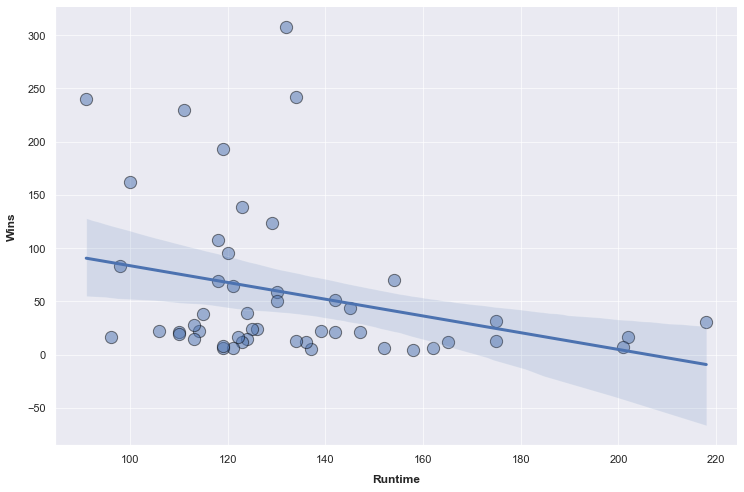

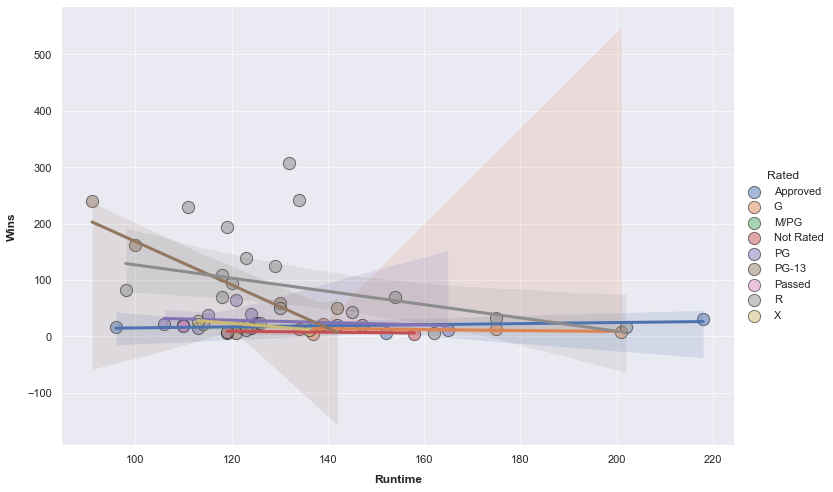

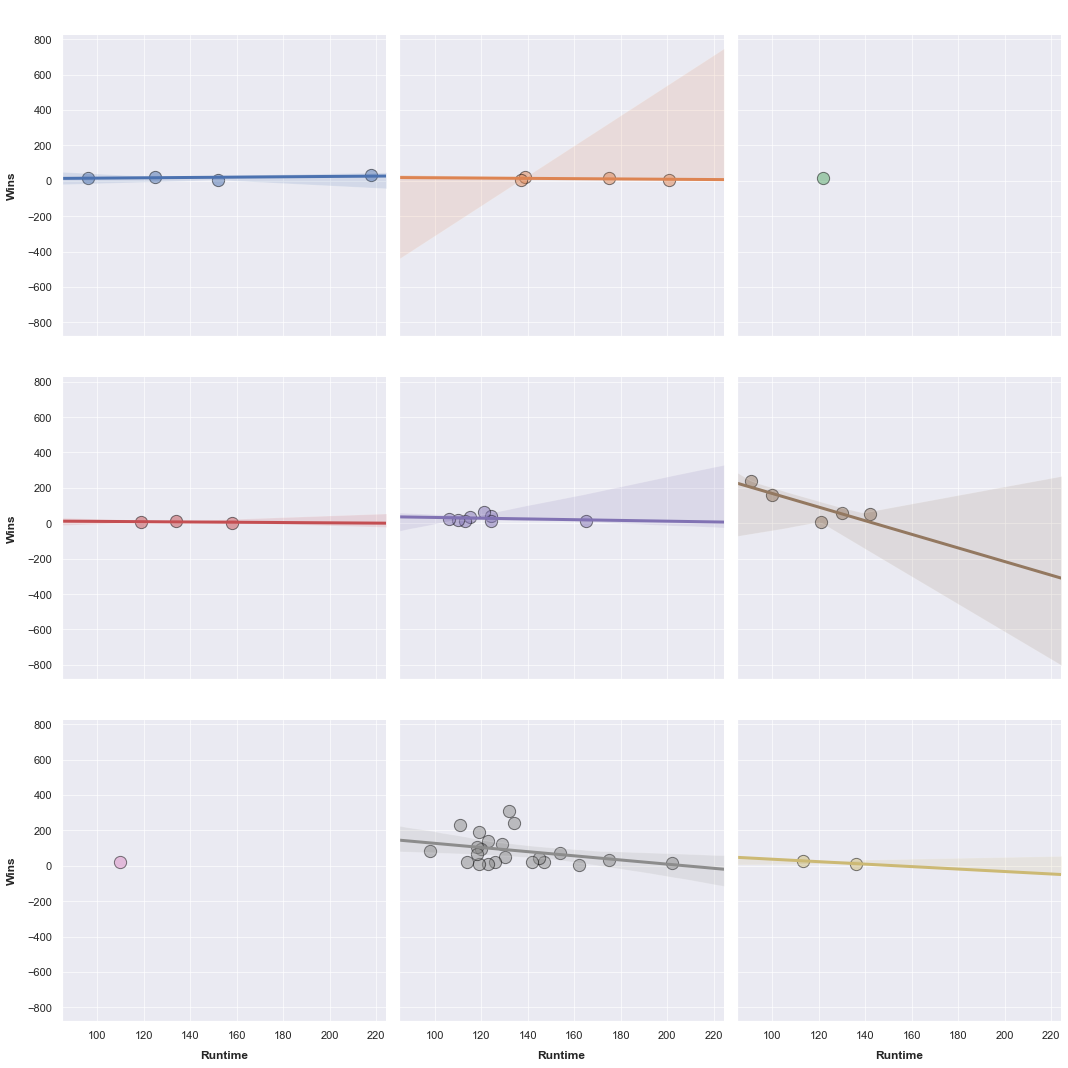

In [11]:
# Create a new DataFrame with only movie titles, their runtime and their wins sorted by runtime
movie_runtimes_and_wins = df[["Title", "Runtime", "Wins", "Rated"]].sort_values(by="Runtime", ascending=False)

# Initial look for potential relationships between the columns
# movie_runtimes_and_wins.corr()
# sns.pairplot(data=movie_runtimes_and_wins)

# Convert Runtime and Wins to float
# lmplot() seems to like float values better than int sometimes
movie_runtimes_and_wins["Runtime"] = movie_runtimes_and_wins["Runtime"].astype(float)
movie_runtimes_and_wins["Wins"] = movie_runtimes_and_wins["Wins"].astype(float)

# Reset to theme defaults
sns.set_theme()

# Plot general runtime vs wins
sns.lmplot(
  x='Runtime', 
  y='Wins', 
  data=movie_runtimes_and_wins, 
  height=7, 
  aspect=1.5,
  scatter_kws=scatter_dots,
  line_kws=line_style,
)

# Plot runtime vs wins for each movie rating
sns.lmplot(
  x='Runtime', 
  y='Wins', 
  data=movie_runtimes_and_wins, 
  hue="Rated", 
  height=7, 
  aspect=1.5,
  scatter_kws=scatter_dots,
  line_kws=line_style,
)

# Plot facet grid of runtime vs wins for each movie rating
g = sns.lmplot(
  x='Runtime', 
  y='Wins', 
  data=movie_runtimes_and_wins, 
  hue="Rated", 
  col="Rated", 
  scatter_kws=scatter_dots,
  line_kws=line_style,
  truncate=False, # Remove some whitespace around the plots
  col_wrap=3,  # Only show 3 plots per row,
)

movie_runtimes_and_wins.corr()

### 4. How many awards and nominations did each movie receive?

By plotting the number of Nominations and Awards for each movie as a horizontal bar chart we can observe each movies results and overall relationships to each other.

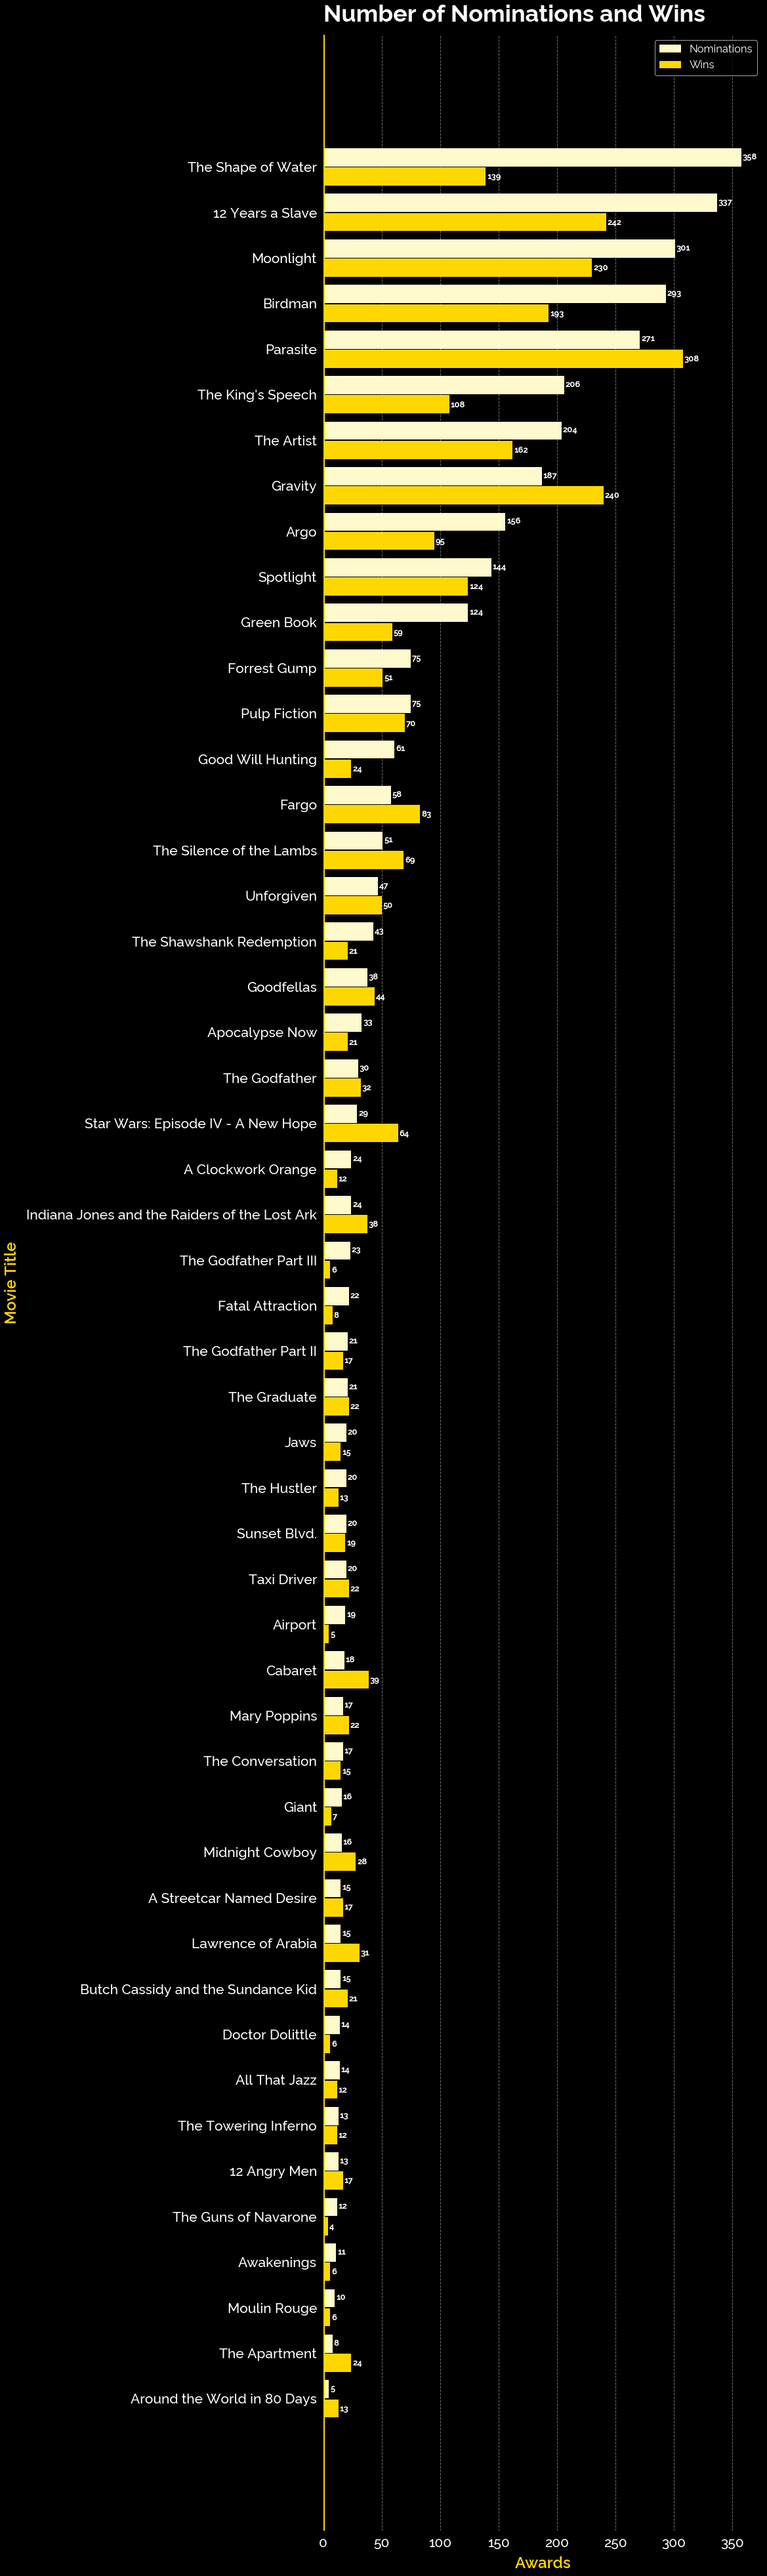

In [12]:
# Create a new dataframe with the movie Title, Nominations, and Wins columns
df_noms_wins = df[["Title", "Nominations", "Wins"]].sort_values(by="Nominations", ascending=True)

Y = df_noms_wins.Title
Y_axis = np.arange(len(Y))

# Set custom theme values again
sns.set_theme(style='dark', font_scale = 1.5, rc=theme_for_bar_charts)

plt.barh(Y_axis + 0.21, df_noms_wins.Nominations, 0.4, label = 'Nominations', color="lemonchiffon", linewidth=0)
plt.barh(Y_axis - 0.21, df_noms_wins.Wins, 0.4, label = 'Wins', color="gold", linewidth=0)

# Include the value of each bar on the plot
for i, v in enumerate(df_noms_wins.Nominations):
  plt.text(
      v + 1, 
      i + 0.17, str(v), 
      color='white',
      # va = 'center', # sets vertical alignment (va) to center
      fontsize=13, # Make font size smaller so it fits better
      weight="bold"
  )
for i, v in enumerate(df_noms_wins.Wins):
  plt.text(
      v + 1, 
      i - 0.27, 
      str(v), 
      color='white',
      fontsize=13, # Make font size smaller so it fits better
      weight="bold"
  )

plt.gcf().set_size_inches(12, 70)
plt.axvline(x=0, linewidth=4, color='gold')
plt.grid(axis='x')
plt.xticks(fontsize=21, weight="medium")
plt.yticks(Y_axis, Y, fontsize=21, weight="medium")
plt.ylabel("Movie Title")
plt.xlabel("Awards")
plt.title("Number of Nominations and Wins")
plt.legend(loc="upper right")
plt.show()

# Check the results
# test_wins = df.Wins[df.Title == 'The Shape of Water']
# test_noms = df.Nominations[df.Title == 'The Shape of Water']
# print(f"The Shape of Water should have {test_wins.values[0]} wins and {test_noms.values[0]} nominations.")

# TODO: There might be an easier way to do this with Seaborn instead of using Matplotlib.

# Alternate visualization if needed
# df_noms_wins_top_5 = df_noms_wins.head(5)
# df_noms_wins_top_5.plot.bar(x='Title', y=['Nominations', 'Wins'], rot=0, figsize=(12, 8))


### 5. Is there a relationship between the amount of box office earnings a movie had and the amount of total nominations the movie received (total nominations = awards wins + award nominations)?

Here I'm using a Linear Model Plot (`lmplot`) with Box Office values along the x axis and the number of Nominations on the y to show the relationship between the two variables. The plot shows a slightly negative relationship, which might be the opposite of what's would be expected. Notice the lower Box Office earnings tend to have more Nominations. This might be because movie studios need to promote movies with lower Box Office earnings and by getting them nominated for awards they can get more attention and more people to see the movie.

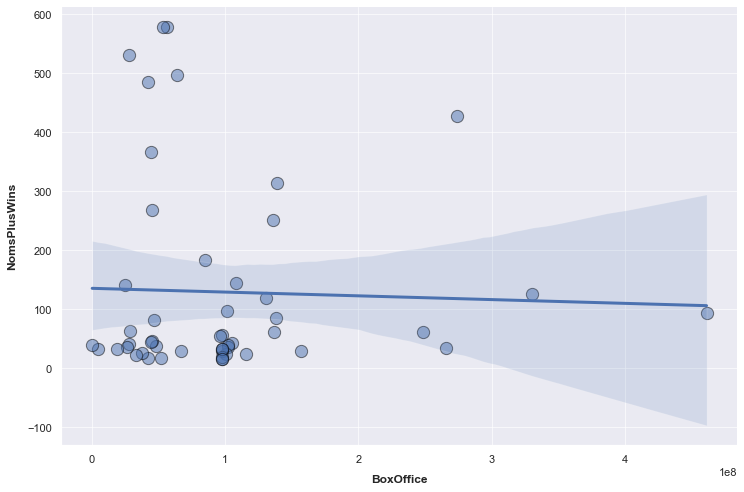

In [13]:
# Create a new DataFrame with only the data we need
movie_bo_noms_wins_sum = df[["BoxOffice", "Nominations", "Wins"]]

# Insert a new column and set it to the sum of Nominations and Wins
movie_bo_noms_wins_sum.insert(1, "NomsPlusWins", movie_bo_noms_wins_sum["Nominations"] + movie_bo_noms_wins_sum["Wins"])

# Drop the Nominations and Wins columns since we don't need them anymore
movie_bo_noms_wins_sum = movie_bo_noms_wins_sum.drop(columns=["Nominations", "Wins"])

# Sort by BoxOffice
movie_bo_noms_wins_sum = movie_bo_noms_wins_sum.sort_values(by="BoxOffice", ascending=False)

# Convert BoxOffice and NomAndWins to float types
movie_bo_noms_wins_sum["BoxOffice"] = movie_bo_noms_wins_sum["BoxOffice"].astype(float)
movie_bo_noms_wins_sum["NomsPlusWins"] = movie_bo_noms_wins_sum["NomsPlusWins"].astype(float)

# Check the result
# movie_bo_nomswinssum

# Initial look for potential relationships between the columns
# display(movie_bo_nomswinssum.corr())
# sns.pairplot(data=movie_bo_nomswinssum)

# Reset to theme defaults
sns.set_theme()

# Plot general runtime vs wins
sns.lmplot(
  x='BoxOffice', 
  y='NomsPlusWins', 
  data=movie_bo_noms_wins_sum, 
  height=7, 
  aspect=1.5,
  scatter_kws=scatter_dots,
  line_kws=line_style,
)

### 6. Is there a relationship between box office earnings and movie runtimes?

Here I'm using a Linear Model Plot (`lmplot`) with Box Office values along the x axis and the Runtime (in minutes) value on the y axis to show the relationship between the two variables. The plot shows a slightly negative relationship. Longer movies tend to earn less at the box office. Looking at the facet plot based on Ratings we can see the relationship between Box Office and Runtime for each Rating. The "G" rating has a stronger negative relationship than the other ratings but more data is needed to make a stronger conclusion.

Additionally, by using the correlation function (`corr()`) we can see the correlation between the two variables is -0.14. This is a weak negative correlation value.

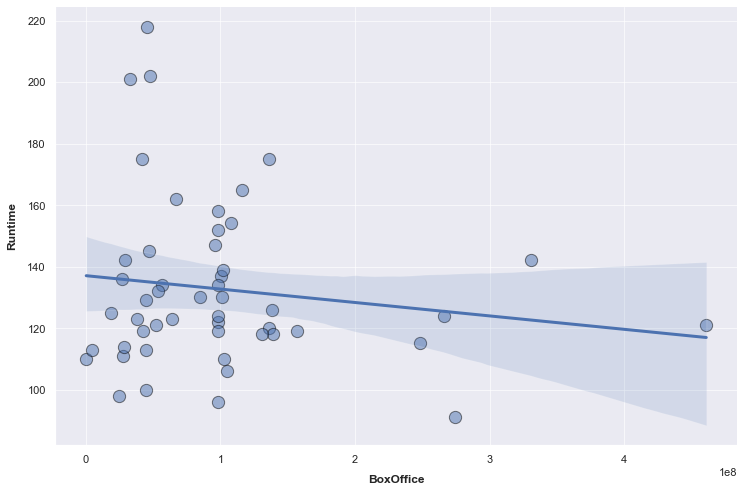

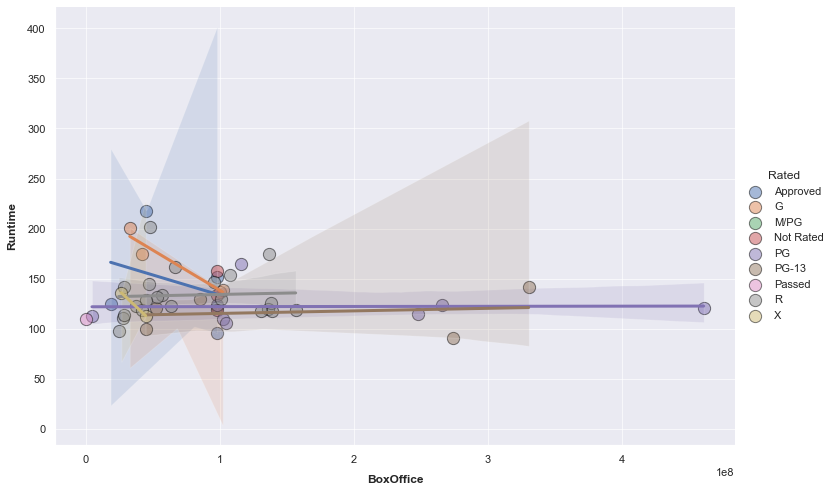

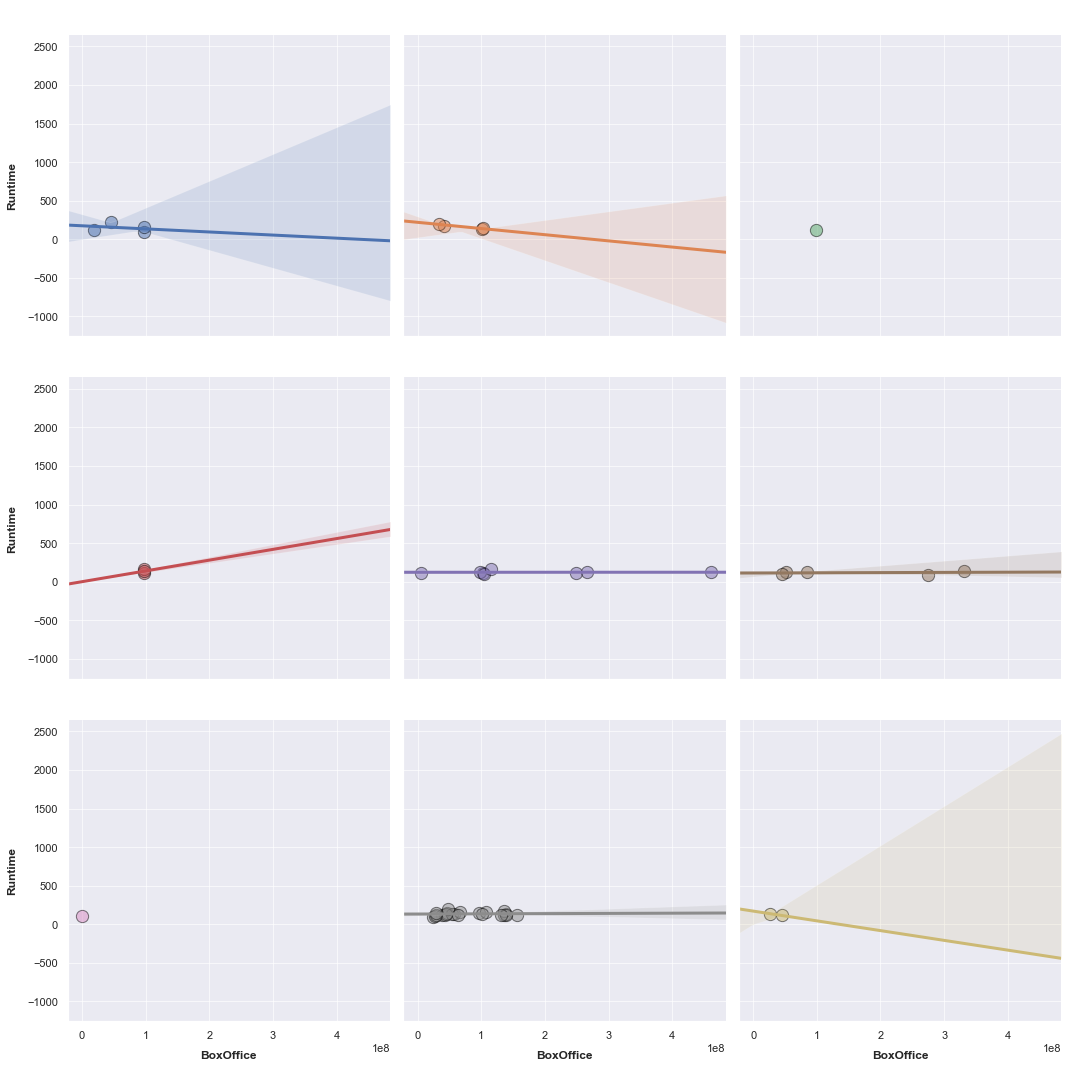

In [14]:
# Create a new DataFrame with only the data we need
movie_bo_runtime = df[["BoxOffice", "Runtime", "Rated"]]

# Check the result
# movie_bo_runtime

# Initial look for potential relationships between the columns
# display(movie_bo_runtime.corr())
# sns.pairplot(data=movie_bo_runtime)

# Plot general boxoffice vs runtime relationship
sns.lmplot(
  x='BoxOffice', 
  y='Runtime', 
  data=movie_bo_runtime,
  height=7, 
  aspect=1.5,
  scatter_kws=scatter_dots,
  line_kws=line_style,
)

# Plot boxoffice vs runtime for each movie rating
sns.lmplot(
  x='BoxOffice', 
  y='Runtime', 
  data=movie_bo_runtime,
  hue="Rated",
  height=7, 
  aspect=1.5,
  scatter_kws=scatter_dots,
  line_kws=line_style,
)

# Plot facet grid of boxoffice vs runtime for each movie rating
g = sns.lmplot(
  x='BoxOffice', 
  y='Runtime', 
  data=movie_bo_runtime,
  hue="Rated",
  col="Rated", 
  scatter_kws=scatter_dots,
  line_kws=line_style,
  truncate=False, # Remove some whitespace around the plots
  col_wrap=3,  # Only show 3 plots per row
)

### 7. How much did each movie earn at the box office?

Sorting movies from highest box office earnings to lowest and then plotting them shows their earnings relationship to eachother. Notably Star Wars: Episode IV was the highest earning movie in the dataset.

Text(0, 0.5, 'Movie Title')

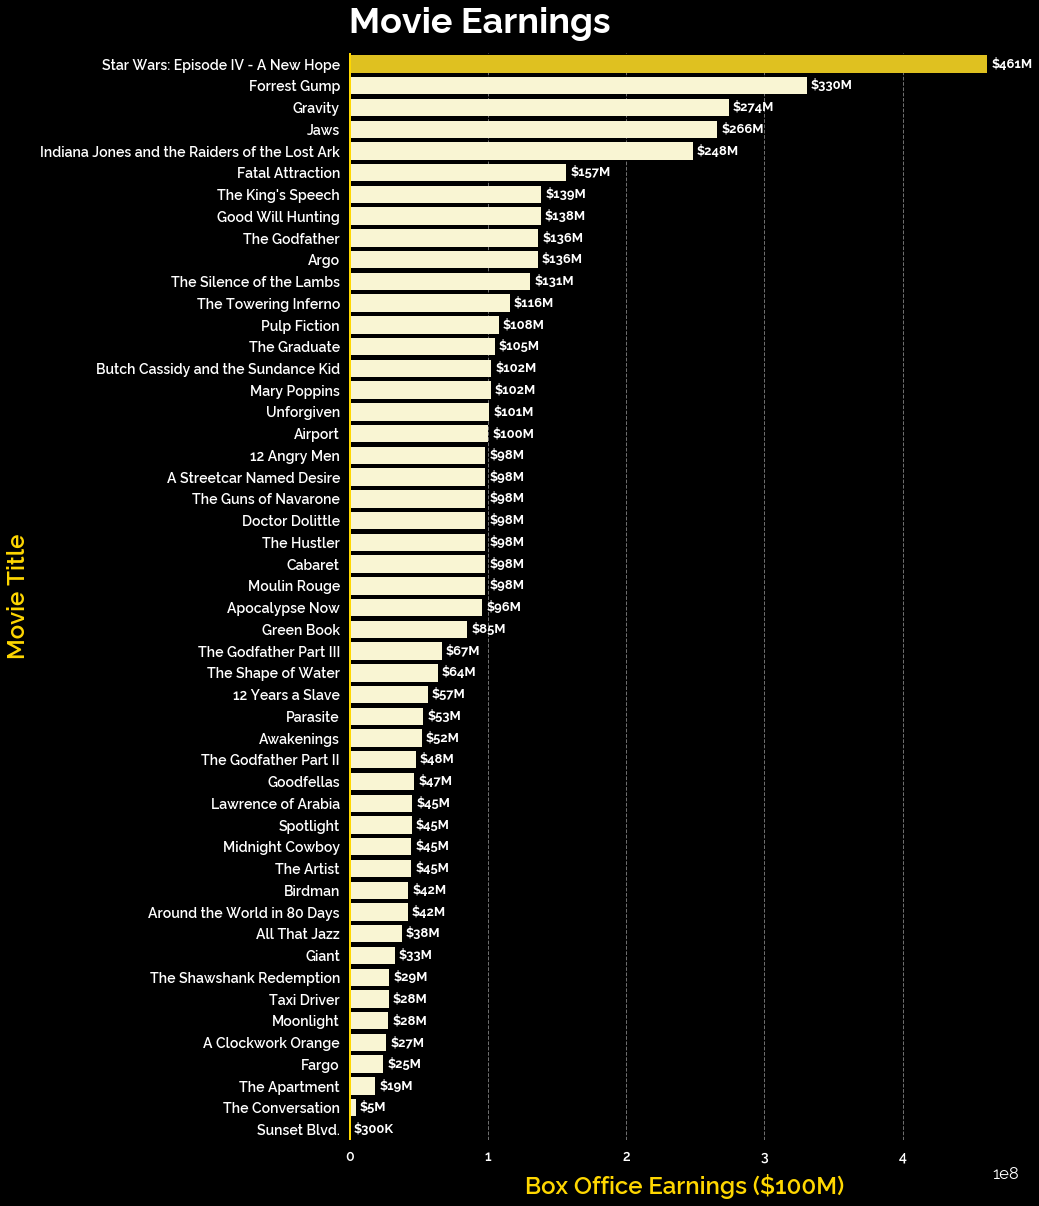

In [15]:
# Plot movies by box office revenue
df_earnings = df.sort_values(by="BoxOffice", ascending=False)

# Set custom theme values again
sns.set_theme(style='dark', font_scale = 1.5, rc=theme_for_bar_charts)

# Use gold for bar with max value and grey/silver for all other bars
cols = ['lemonchiffon' if (x < max(df_earnings.BoxOffice)) else 'gold' for x in df_earnings.BoxOffice]

# Plot each movie with its runtime length using specified colors
ax = sns.barplot(data=df_earnings, x="BoxOffice", y="Title", palette=cols, linewidth=0)

# Function to humanize BoxOffice values
# Based on https://stackoverflow.com/questions/579310/formatting-long-numbers-as-strings/45846841#answer-579376
def humanize_box_office(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.0f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

# Label each bar
for b in ax.patches:
  height = b.get_height() # height of each horizontal bar is the same
  width = b.get_width() # width of bar is the value of the bar
  # adding text to each bar
  ax.text(
    x = width + 3000000, # x-coordinate position of data label, padded to right of bar
    y = b.get_y() + (height / 2), # y-coordinate position of data label, padded to be in the middle of the bar
    s = f'${humanize_box_office(width)}', # data label, formatted to ignore decimals
    # s = '{:.0f}'.format(humanize_box_office(width)), # data label, formatted to ignore decimals
    va = 'center', # sets vertical alignment (va) to center
    fontsize=13, # Make font size smaller so it fits better
    weight="bold"
  )

ax.axvline(x=0, linewidth=4, color='gold')
plt.grid(axis='x')
plt.gcf().set_size_inches(12, 20)
plt.xticks(fontsize=14, weight="semibold")
plt.yticks(fontsize=14, weight="semibold")
plt.title('Movie Earnings')
plt.xlabel('Box Office Earnings ($100M)')
plt.ylabel('Movie Title')

### 8. What is the total count of each genre present in the dataset? (How many times does fantasy, drama, adventure, etc. show up)

The converted movie data format includes a column for each genre such as is_Genre_Crime, is_Genre_Biography, is_Genre_Thriller, etc... and True or False values depending if the movie belongs to each genre. By summing how many True values appear in each of the is_Genre_* columns a total movie count is found. After sorting the results highest to lowest it becomes clear the Drama genre has the most movies than the other genres.

Text(0, 0.5, 'Genre Name')

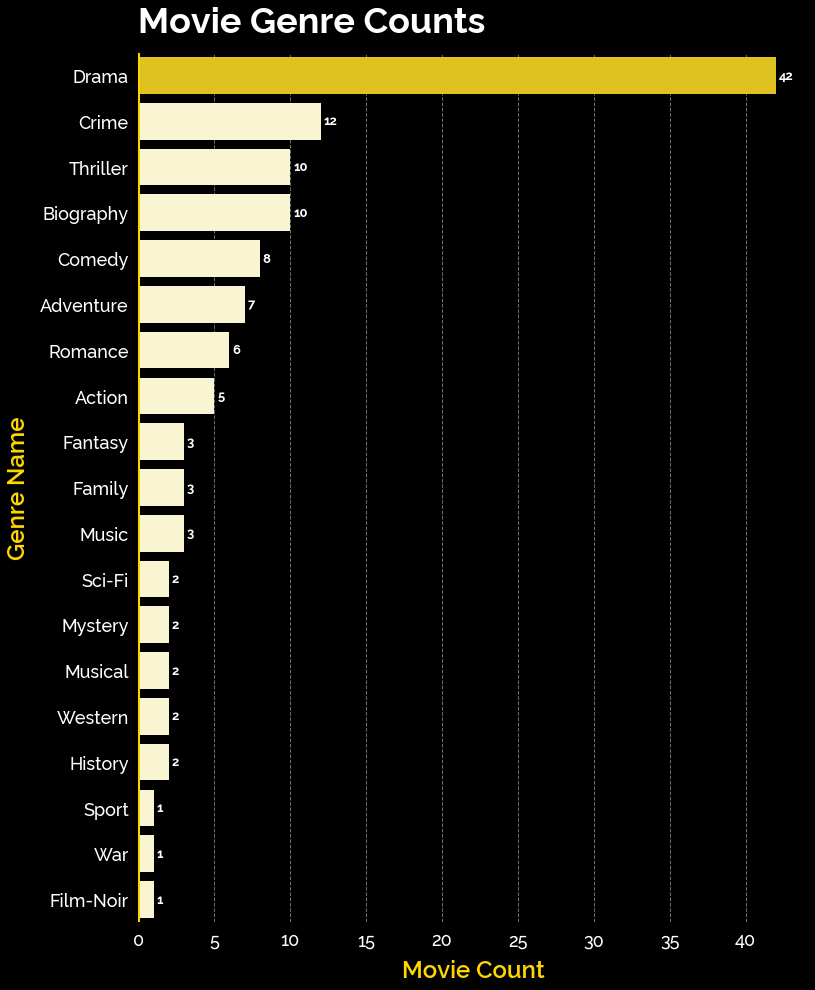

In [16]:
# Get the count of each column that starts with the string is_Genre
genre_counts = df.filter(regex="^is_Genre").sum().sort_values(ascending=False)

# Remove the is_Genre_ prefix from the index
genre_counts.index = genre_counts.index.str.replace("is_Genre_", "")

# Make the series a dataframe with column names
df_genre_counts = pd.DataFrame(genre_counts).reset_index()
df_genre_counts.columns = ['Genre', 'Count']

# Use gold for bar with max value and grey/silver for all other bars
cols = ['lemonchiffon' if (x < max(df_genre_counts.Count)) else 'gold' for x in df_genre_counts.Count]

# Plot each movie with its count using specified colors
ax = sns.barplot(data=df_genre_counts, x="Count", y="Genre", palette=cols, linewidth=0)

# Label each bar
for b in ax.patches:
  height = b.get_height() # height of each horizontal bar is the same
  width = b.get_width() # width of bar is the value of the bar
  # adding text to each bar
  ax.text(
    x = width + .2, # x-coordinate position of data label, padded to right of bar
    y = b.get_y() + (height / 2), # y-coordinate position of data label, padded to be in the middle of the bar
    s = '{:.0f}'.format(width), # data label, formatted to ignore decimals
    va = 'center', # sets vertical alignment (va) to center
    fontsize=13, # Make font size smaller so it fits better
    weight="bold"
  )

ax.axvline(x=0, linewidth=4, color='gold')
plt.grid(axis='x')
plt.gcf().set_size_inches(12, 16)
plt.xticks(fontsize=18, weight="medium")
plt.yticks(fontsize=18, weight="medium")
plt.title('Movie Genre Counts')
plt.xlabel('Movie Count')
plt.ylabel('Genre Name')